# 🎬 Exploration des Données - Box Office des Films 📊

Ce notebook effectue l'analyse exploratoire des données (EDA) sur le dataset TMDB.
On va charger les données, les nettoyer, effectuer quelques transformations
et visualiser les aspects clés.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Configuration pour les plots (optionnel, mais sympa)
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 7) # Taille par défaut des figures

## 1. Chargement des Données

On charge le fichier CSV et on regarde les premières lignes et la taille du dataset.


In [2]:
FILE_PATH = '../TMDB_movie_dataset_v11.csv' # Utilisation du nom générique vu dans l'EDA.md

print(f"Chargement des données depuis: {FILE_PATH}")
try:
    df_brut = pd.read_csv(FILE_PATH)
    print("Chargement réussi.")
    print("Aperçu des données:")
    display(df_brut.head(3))
    print(f"Shape initiale: {df_brut.shape}")
except FileNotFoundError:
    print(f"Erreur: Le fichier {FILE_PATH} n'a pas été trouvé. Vérifiez le chemin.")
    # Stopper l'exécution ou gérer l'erreur autrement si nécessaire
    df_brut = pd.DataFrame() # Créer un dataframe vide pour éviter les erreurs suivantes


Chargement des données depuis: ../TMDB_movie_dataset_v11.csv
Chargement réussi.
Aperçu des données:


,id,title,vote_average,vote_count,status,release_date,revenue,runtime,adult,backdrop_path,...,original_title,overview,popularity,poster_path,tagline,genres,production_companies,production_countries,spoken_languages,keywords
0,27205,Inception,8.364,34495,Released,2010-07-15,825532764,148,False,/8ZTVqvKDQ8emSGUEMjsS4yHAwrp.jpg,...,Inception,"Cobb, a skilled thief who commits corporate es...",83.952,/oYuLEt3zVCKq57qu2F8dT7NIa6f.jpg,Your mind is the scene of the crime.,"Action, Science Fiction, Adventure","Legendary Pictures, Syncopy, Warner Bros. Pict...","United Kingdom, United States of America","English, French, Japanese, Swahili","rescue, mission, dream, airplane, paris, franc..."
1,157336,Interstellar,8.417,32571,Released,2014-11-05,701729206,169,False,/pbrkL804c8yAv3zBZR4QPEafpAR.jpg,...,Interstellar,The adventures of a group of explorers who mak...,140.241,/gEU2QniE6E77NI6lCU6MxlNBvIx.jpg,Mankind was born on Earth. It was never meant ...,"Adventure, Drama, Science Fiction","Legendary Pictures, Syncopy, Lynda Obst Produc...","United Kingdom, United States of America",English,"rescue, future, spacecraft, race against time,..."
2,155,The Dark Knight,8.512,30619,Released,2008-07-16,1004558444,152,False,/nMKdUUepR0i5zn0y1T4CsSB5chy.jpg,...,The Dark Knight,Batman raises the stakes in his war on crime. ...,130.643,/qJ2tW6WMUDux911r6m7haRef0WH.jpg,Welcome to a world without rules.,"Drama, Action, Crime, Thriller","DC Comics, Legendary Pictures, Syncopy, Isobel...","United Kingdom, United States of America","English, Mandarin","joker, sadism, chaos, secret identity, crime f..."


Shape initiale: (1205570, 24)


## 2. Nettoyage Initial

On supprime les colonnes jugées non pertinentes pour notre objectif (prédiction de revenus)
et on applique quelques filtres initiaux pour enlever les données aberrantes ou incomplètes.


In [3]:
if not df_brut.empty:
    print("Début du nettoyage initial...")
    # Copie pour éviter les SettingWithCopyWarning
    df = df_brut.copy()

    # Colonnes à supprimer
    cols_to_drop = ['backdrop_path', 'poster_path', 'popularity', 'home_page', 'vote_average', 'vote_count', 'adult', 'id']
    # Note: J'ai ajouté plus de colonnes textuelles/id ici car elles ne sont pas utilisées dans l'EDA numérique
    # et nécessiteraient du NLP pour être exploitées dans un modèle.
    # 'popularity' est aussi retirée comme dans l'EDA.md.
    df = df.drop(columns=cols_to_drop, errors='ignore') # errors='ignore' au cas où une colonne serait déjà absente
    print(f"Colonnes supprimées: {cols_to_drop}")

    # Filtrage initial basé sur l'EDA.md
    # Convertir release_date avant de filtrer
    df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')

    initial_rows = df.shape[0]

    # Filtres:
    # - Date de sortie valide et avant 2024
    df = df[pd.notna(df['release_date'])]
    df = df[df['release_date'] < pd.to_datetime('2024-01-01')]
    # - Compagnies de production non nulles (proxy de "vrai" film?)
    df = df[pd.notna(df['production_companies'])]
    # - Revenu max raisonnable (vu dans EDA.md)
    df = df[df['revenue'] < 3.1e9] # ~ Avatar + marge?

    print(f"Filtrage initial: {initial_rows} -> {df.shape[0]} lignes restantes.")


Début du nettoyage initial...
Colonnes supprimées: ['backdrop_path', 'poster_path', 'popularity', 'home_page', 'vote_average', 'vote_count', 'adult', 'id']
Filtrage initial: 1205570 -> 492772 lignes restantes.


In [4]:
df.head()

,title,status,release_date,revenue,runtime,budget,homepage,imdb_id,original_language,original_title,overview,tagline,genres,production_companies,production_countries,spoken_languages,keywords
0,Inception,Released,2010-07-15,825532764,148,160000000,https://www.warnerbros.com/movies/inception,tt1375666,en,Inception,"Cobb, a skilled thief who commits corporate es...",Your mind is the scene of the crime.,"Action, Science Fiction, Adventure","Legendary Pictures, Syncopy, Warner Bros. Pict...","United Kingdom, United States of America","English, French, Japanese, Swahili","rescue, mission, dream, airplane, paris, franc..."
1,Interstellar,Released,2014-11-05,701729206,169,165000000,http://www.interstellarmovie.net/,tt0816692,en,Interstellar,The adventures of a group of explorers who mak...,Mankind was born on Earth. It was never meant ...,"Adventure, Drama, Science Fiction","Legendary Pictures, Syncopy, Lynda Obst Produc...","United Kingdom, United States of America",English,"rescue, future, spacecraft, race against time,..."
2,The Dark Knight,Released,2008-07-16,1004558444,152,185000000,https://www.warnerbros.com/movies/dark-knight/,tt0468569,en,The Dark Knight,Batman raises the stakes in his war on crime. ...,Welcome to a world without rules.,"Drama, Action, Crime, Thriller","DC Comics, Legendary Pictures, Syncopy, Isobel...","United Kingdom, United States of America","English, Mandarin","joker, sadism, chaos, secret identity, crime f..."
3,Avatar,Released,2009-12-15,2923706026,162,237000000,https://www.avatar.com/movies/avatar,tt0499549,en,Avatar,"In the 22nd century, a paraplegic Marine is di...",Enter the world of Pandora.,"Action, Adventure, Fantasy, Science Fiction","Dune Entertainment, Lightstorm Entertainment, ...","United States of America, United Kingdom","English, Spanish","future, society, culture clash, space travel, ..."
4,The Avengers,Released,2012-04-25,1518815515,143,220000000,https://www.marvel.com/movies/the-avengers,tt0848228,en,The Avengers,When an unexpected enemy emerges and threatens...,Some assembly required.,"Science Fiction, Action, Adventure",Marvel Studios,United States of America,"English, Hindi, Russian","new york city, superhero, shield, based on com..."


## 3. Analyse et Nettoyage : Durée (`runtime`) & Revenus (`revenue`)

On examine la distribution de la durée des films et des revenus pour identifier et potentiellement
exclure les valeurs extrêmes ou non pertinentes (ex: courts métrages, films sans revenus significatifs).



Analyse de la durée (runtime):
count    492772.000000
mean         67.268802
std          62.070105
min           0.000000
25%          10.000000
50%          77.000000
75%          99.000000
max       12480.000000
Name: runtime, dtype: float64


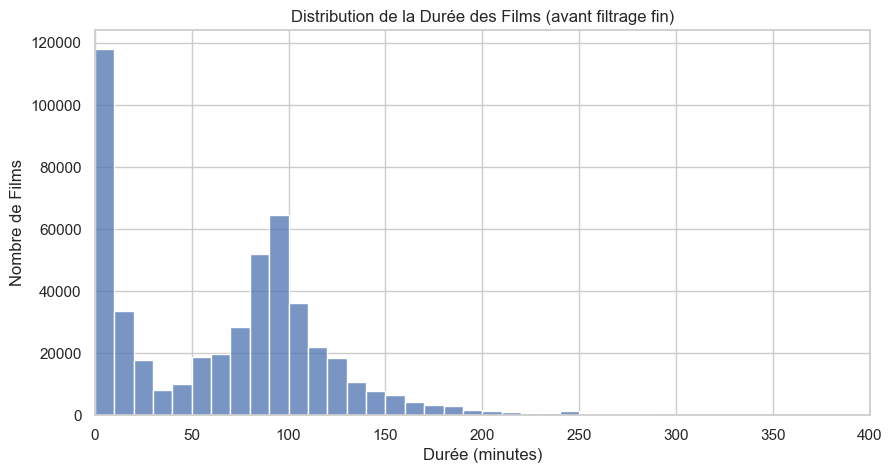

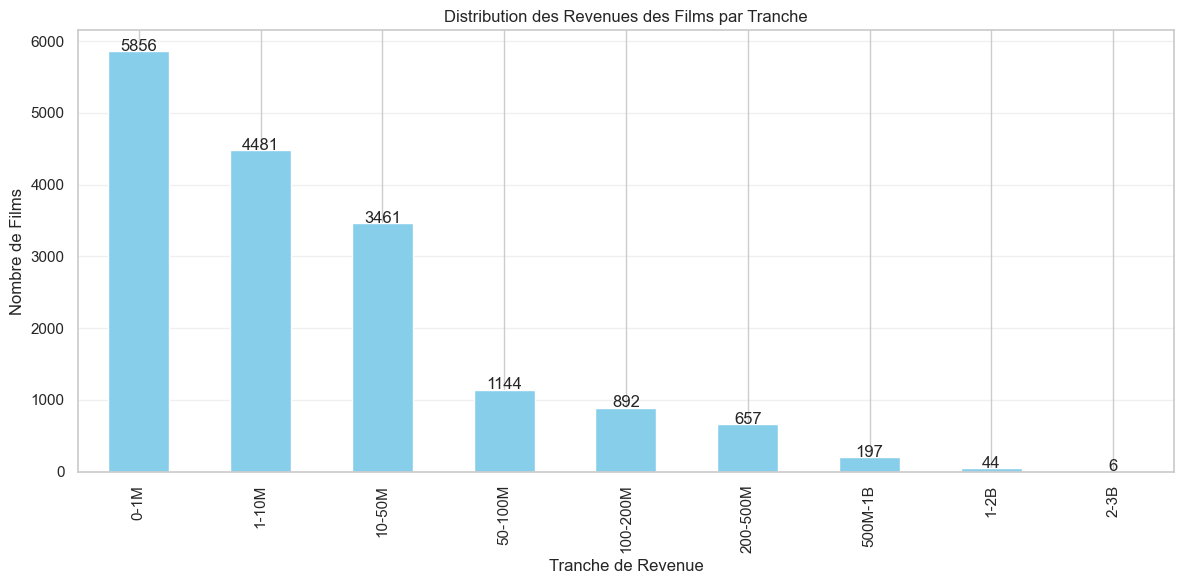


Filtrage basé sur runtime [30, 280] et revenue > 1000:
Passage de 492772 à 14853 lignes.


In [5]:
if not df.empty:
    print("\nAnalyse de la durée (runtime):")
    print(df['runtime'].describe())

    # Visualisation rapide de la distribution du runtime (avant filtrage fin)
    plt.figure(figsize=(10, 5))
    sns.histplot(df['runtime'].dropna(), bins=np.arange(0, 300, 10), kde=False)
    plt.title('Distribution de la Durée des Films (avant filtrage fin)')
    plt.xlabel('Durée (minutes)')
    plt.ylabel('Nombre de Films')
    plt.xlim(0, 400) # Zoom sur la plage la plus courante
    
    revenue_bins = pd.cut(df['revenue'].dropna(), 
                     bins=[0, 1e6, 10e6, 50e6, 100e6, 200e6, 500e6, 1e9, 2e9, 3e9],
                     labels=['0-1M', '1-10M', '10-50M', '50-100M', '100-200M', '200-500M', '500M-1B', '1-2B', '2-3B'])

    bin_counts = revenue_bins.value_counts().sort_index()
    plt.figure(figsize=(12, 6))
    bin_counts.plot(kind='bar', color='skyblue')
    plt.title('Distribution des Revenues des Films par Tranche')
    plt.xlabel('Tranche de Revenue')
    plt.ylabel('Nombre de Films')
    for i, v in enumerate(bin_counts):
        plt.text(i, v + 5, f'{v}', ha='center')
    plt.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    plt.show()

    # Application des filtres vus dans EDA.md
    rows_before_filter = df.shape[0]
    df_clean = df[
        (df['runtime'] >= 30) &     # Durée min raisonnable pour un film
        (df['runtime'] <= 280) &    # Durée max raisonnable
        (df['revenue'] > 1000) &    # Revenu minimum pour être considéré commercial
        pd.notna(df['release_date']) # Redondant si déjà filtré, mais sûr
    ].copy() # .copy() pour éviter les warnings

    print(f"\nFiltrage basé sur runtime [30, 280] et revenue > 1000:")
    print(f"Passage de {rows_before_filter} à {df_clean.shape[0]} lignes.")
else:
    print("Skipping runtime/revenue analysis due to empty dataframe.")
    df_clean = pd.DataFrame()


## 4. Ingénierie des Caractéristiques (Feature Engineering)

On crée de nouvelles caractéristiques utiles à partir de celles existantes.
- Extraction de l'année et du mois de sortie.
- Transformation logarithmique du revenu pour normaliser sa distribution.


In [6]:
print("Création de nouvelles caractéristiques:")
# Date de sortie - déjà convertie, on extrait année/mois
df_clean['release_year'] = df_clean['release_date'].dt.year
df_clean['release_month'] = df_clean['release_date'].dt.month
print("- Année et Mois de sortie extraits.")

# Transformation log(1+x) du revenu
# Le +1 évite log(0) et gère les revenus très faibles.
df_clean['log_revenue'] = np.log1p(df_clean['revenue'])
print("- Revenu transformé en log(1 + revenue).")

print("\nAperçu des données nettoyées et enrichies:")
display(df_clean[['title', 'revenue', 'log_revenue', 'runtime', 'release_date', 'release_year', 'release_month']].head())

Création de nouvelles caractéristiques:
- Année et Mois de sortie extraits.
- Revenu transformé en log(1 + revenue).

Aperçu des données nettoyées et enrichies:


,title,revenue,log_revenue,runtime,release_date,release_year,release_month
0,Inception,825532764,20.531540,148,2010-07-15,2010,7
1,Interstellar,701729206,20.369058,169,2014-11-05,2014,11
2,The Dark Knight,1004558444,20.727814,152,2008-07-16,2008,7
3,Avatar,2923706026,21.796118,162,2009-12-15,2009,12
4,The Avengers,1518815515,21.141197,143,2012-04-25,2012,4


## 5. Visualisations Exploratoires

Maintenant que les données sont propres, on explore les relations entre les variables,
en particulier celles liées à notre cible : le revenu (`log_revenue`).


### 5.1 Distribution du Revenu (Log-Transformé)

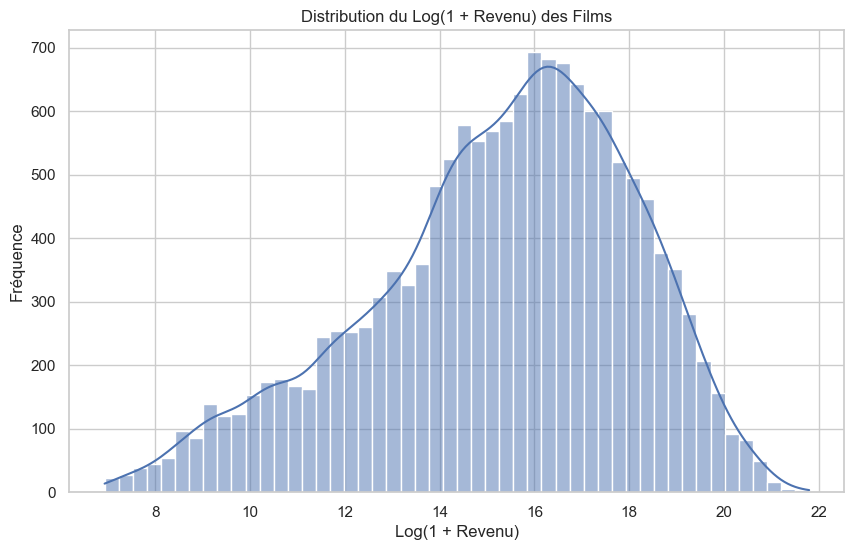

Commentaire: La transformation log a rendu la distribution plus symétrique, proche d'une normale, ce qui est bénéfique pour de nombreux modèles.


In [7]:
plt.figure(figsize=(10, 6))
sns.histplot(df_clean['log_revenue'].dropna(), kde=True, bins=50)
plt.title('Distribution du Log(1 + Revenu) des Films')
plt.xlabel('Log(1 + Revenu)')
plt.ylabel('Fréquence')
plt.show()
print("Commentaire: La transformation log a rendu la distribution plus symétrique, proche d'une normale, ce qui est bénéfique pour de nombreux modèles.")

### 5.2 Top 10 des Films par Revenu Brut

/var/folders/ky/xc03k_hx12j3t7fq6f7by3600000gn/T/ipykernel_10541/3946037321.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_movies, y='title', x='revenue', palette='viridis')


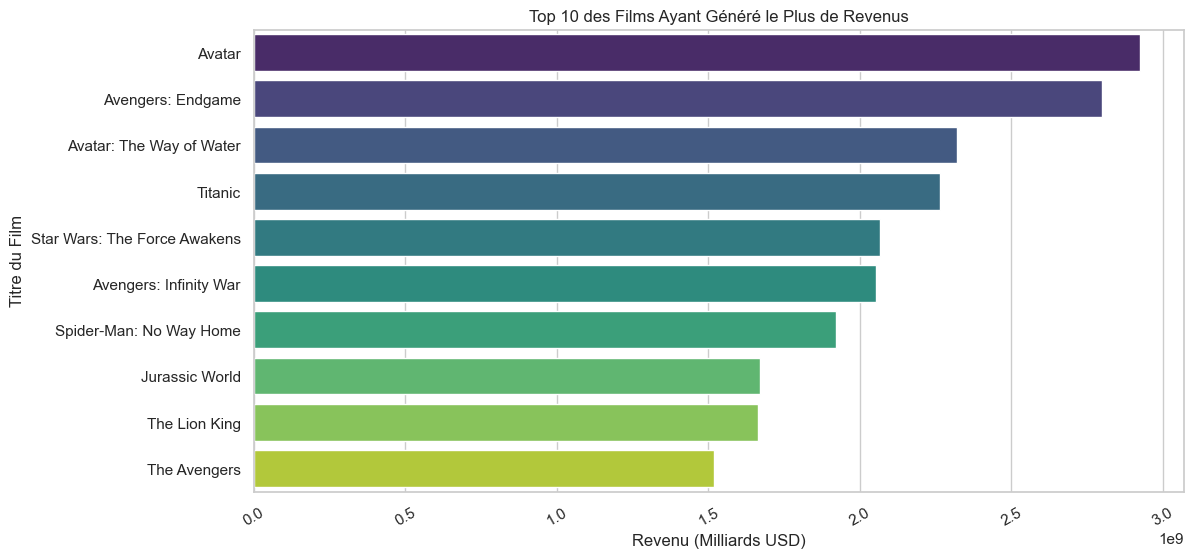

In [8]:
top_movies = df_clean.nlargest(10, 'revenue')[['title', 'revenue', 'release_year']]
plt.figure(figsize=(12, 6))
sns.barplot(data=top_movies, y='title', x='revenue', palette='viridis')
plt.title('Top 10 des Films Ayant Généré le Plus de Revenus')
plt.xlabel('Revenu (Milliards USD)')
plt.ylabel('Titre du Film')
plt.xticks(rotation=30)
plt.ticklabel_format(style='sci', axis='x', scilimits=(9,9)) # Format scientifique pour milliards
plt.show()

### 5.3 Revenu Moyen par Genre Principal

Attention: Un film peut avoir plusieurs genres. Ici, on considère chaque genre indépendamment.


/var/folders/ky/xc03k_hx12j3t7fq6f7by3600000gn/T/ipykernel_10541/3589709486.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=genre_means.values, y=genre_means.index, palette='rocket')


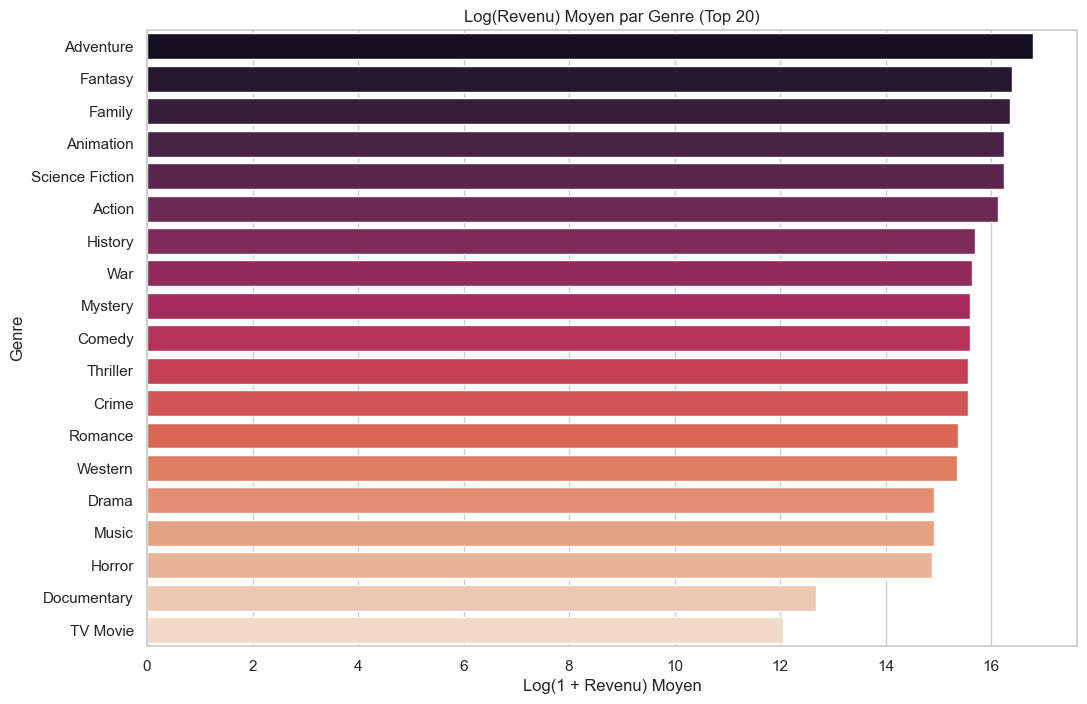

Commentaire: Certains genres semblent associés à des revenus moyens plus élevés.


In [9]:
# Séparer les genres (suppose une chaîne séparée par ', ')
# Gérer les valeurs NaN dans 'genres' avant de splitter
df_clean['genre_list'] = df_clean['genres'].fillna('').str.split(', ')

genre_data = []
for idx, row in df_clean.iterrows():
    # On vérifie si c'est bien une liste (peut être [''] si NaN original)
    if isinstance(row['genre_list'], list) and row['genre_list'] != ['']:
        for genre in row['genre_list']:
             if genre: # Eviter les genres vides si la séparation crée des strings vides
                genre_data.append({'genre': genre.strip(), 'log_revenue': row['log_revenue'], 'revenue': row['revenue']})

if genre_data:
    genre_df = pd.DataFrame(genre_data)
    # Calculer la moyenne du log_revenue par genre
    genre_means = genre_df.groupby('genre')['log_revenue'].mean().sort_values(ascending=False).head(20) # Top 20 genres

    plt.figure(figsize=(12, 8))
    sns.barplot(x=genre_means.values, y=genre_means.index, palette='rocket')
    plt.title('Log(Revenu) Moyen par Genre (Top 20)')
    plt.xlabel('Log(1 + Revenu) Moyen')
    plt.ylabel('Genre')
    plt.show()
    print("Commentaire: Certains genres semblent associés à des revenus moyens plus élevés.")
else:
    print("Impossible de calculer les revenus par genre (peut-être aucune donnée de genre valide).")

### 5.4 Revenu Moyen par Mois de Sortie (Saisonnalité)

/var/folders/ky/xc03k_hx12j3t7fq6f7by3600000gn/T/ipykernel_10541/625359672.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=monthly_revenue, x='release_month', y='log_revenue', palette='cool')


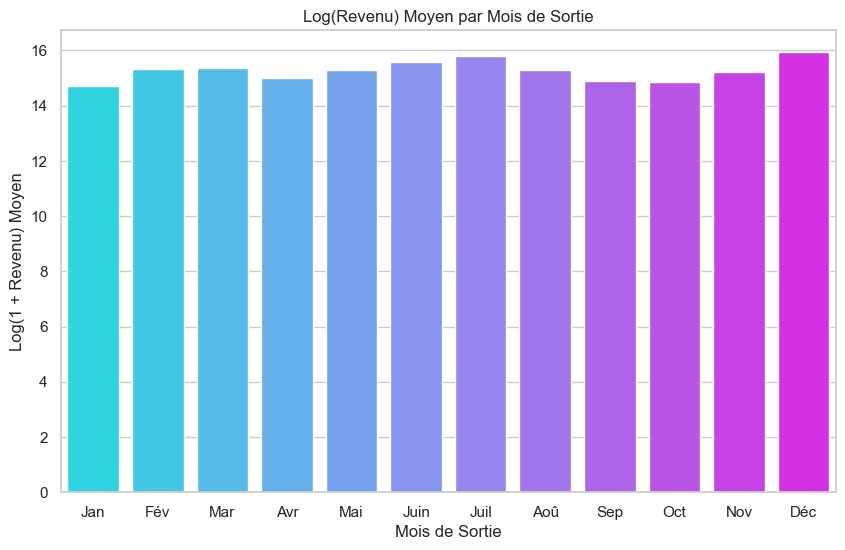

Commentaire: On observe une possible saisonnalité, avec des pics pendant l'été et en fin d'année.


In [10]:
monthly_revenue = df_clean.groupby('release_month')['log_revenue'].mean().reset_index()
plt.figure(figsize=(10, 6))
sns.barplot(data=monthly_revenue, x='release_month', y='log_revenue', palette='cool')
plt.title('Log(Revenu) Moyen par Mois de Sortie')
plt.xlabel('Mois de Sortie')
plt.ylabel('Log(1 + Revenu) Moyen')
plt.xticks(ticks=range(12), labels=['Jan', 'Fév', 'Mar', 'Avr', 'Mai', 'Juin', 'Juil', 'Aoû', 'Sep', 'Oct', 'Nov', 'Déc'])
plt.show()
print("Commentaire: On observe une possible saisonnalité, avec des pics pendant l'été et en fin d'année.")

### 5.5 Relation Durée vs. Revenu

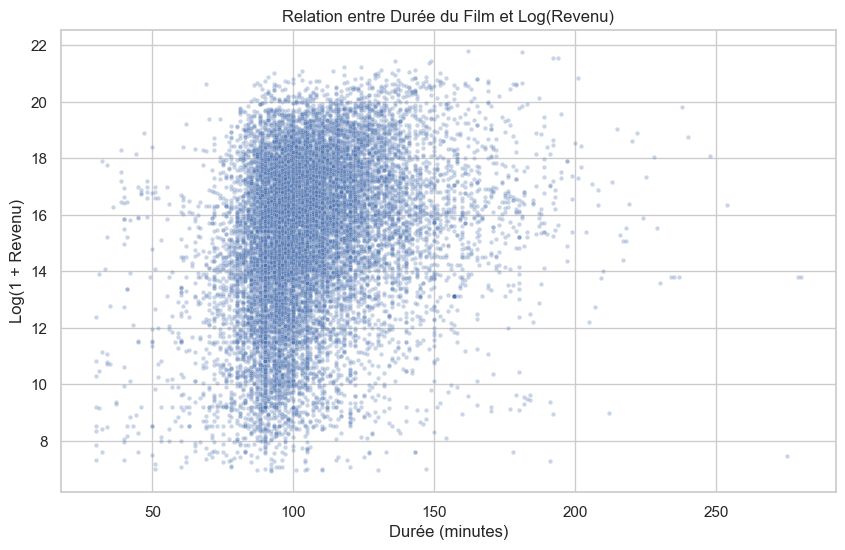

Commentaire: Il ne semble pas y avoir de relation linéaire forte, mais les films très courts ou très longs génèrent rarement les revenus les plus élevés.


In [11]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_clean, x='runtime', y='log_revenue', alpha=0.3, s=10) # alpha et s réduits pour la densité
plt.title('Relation entre Durée du Film et Log(Revenu)')
plt.xlabel('Durée (minutes)')
plt.ylabel('Log(1 + Revenu)')
plt.show()
print("Commentaire: Il ne semble pas y avoir de relation linéaire forte, mais les films très courts ou très longs génèrent rarement les revenus les plus élevés.")

### 5.6 Matrice de Corrélation (Variables Numériques Sélectionnées)

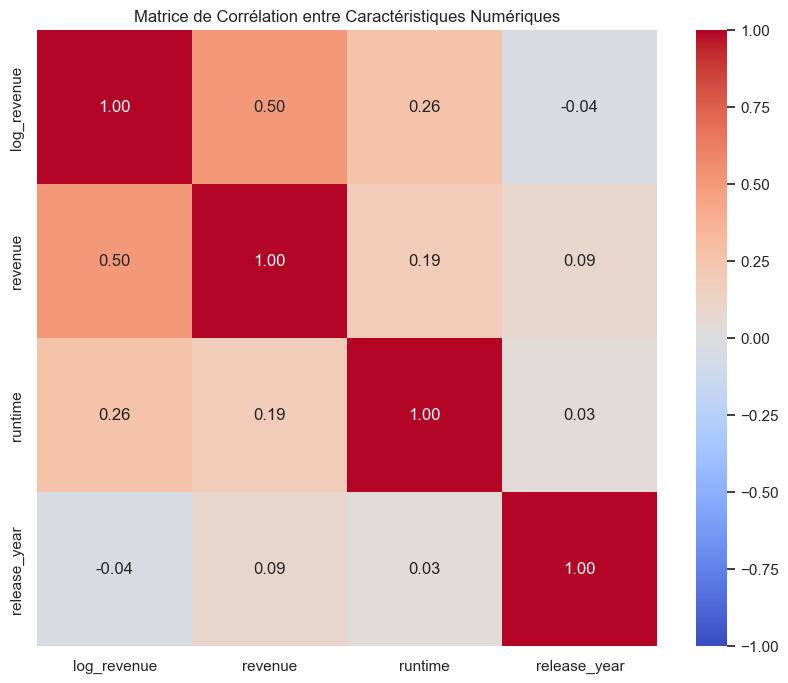

Commentaire: `log_revenue` montre une corrélation positive notable avec `revenue` (logique), et plus faible avec `runtime`. `release_year` a une corrélation faible.


In [14]:
# Sélectionner les colonnes numériques pertinentes pour la corrélation
numeric_cols = ['log_revenue', 'revenue', 'runtime', 'release_year']
# Vérifier si les colonnes existent avant de calculer la corrélation
existing_numeric_cols = [col for col in numeric_cols if col in df_clean.columns and pd.api.types.is_numeric_dtype(df_clean[col])]

if len(existing_numeric_cols) > 1:
    correlation_matrix = df_clean[existing_numeric_cols].corr()

    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
    plt.title('Matrice de Corrélation entre Caractéristiques Numériques')
    plt.show()
    print("Commentaire: `log_revenue` montre une corrélation positive notable avec `revenue` (logique), et plus faible avec `runtime`. `release_year` a une corrélation faible.")
else:
    print("Pas assez de colonnes numériques pour calculer une matrice de corrélation.")

## 6. Conclusion de l'EDA

Cette exploration initiale a permis de :
- Nettoyer les données en retirant les valeurs aberrantes et non pertinentes.
- Transformer la variable cible (`revenue` -> `log_revenue`) pour la modélisation.
- Identifier des relations potentielles :
    - Saisonnalité des sorties.
    - Effet non linéaire de la durée (`runtime`).
    - Différences de revenus moyens entre genres.

Prochaines étapes : Préparer ces données pour entraîner des modèles de Machine Learning. On pourrait sauvegarder `df_clean` pour l'utiliser dans le notebook de modélisation.


In [15]:
try:
    clean_file_path = '../TMDB_cleaned_data.csv'
    df_clean.to_csv(clean_file_path, index=False)
    print(f"\nDonnées nettoyées sauvegardées dans : {clean_file_path}")
except Exception as e:
    print(f"\nErreur lors de la sauvegarde du fichier nettoyé: {e}")


Données nettoyées sauvegardées dans : ../TMDB_cleaned_data.csv
